<a href="https://colab.research.google.com/github/SaikumarReddyY/ExampleNew/blob/master/ESATCNN_V6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract
A Convolutional Neural Network based image classification model was successfully applied to the EuroSAT dataset with 10 class labels. Several dropout probabilities ranging 0 to 0.999 are tested, however, model with d=0 was observed to have the highest accuracies. Training and testing accuracies of 86% and 71%, respectively, are reported for d=0 even with a limited runs of ten epochs. The model outputs, such as accuracies, training losses are logged using tensorboard. Confusion matrices and corresponding heatmaps are also logged and saved to visualise the class accuracies. It was observed that the Highway and River, Herbaceous Vegetation and Permanent Crop, are the two sets of images where the model performs poorly. Augmenting the data for these images can improve the class accuracy and there-by the overall accuracy.

## Special instructions
* Please make sure the data is sampled locally. For example running from google drive without high ram can be computationally time taking. I have ensured this by unpacking data from .zip file every time.
* I ran the code on Tesla-P100-PCIE-16GB GPU. This took me 21 minutes in total.
* I have used inline tensorboard call to visualise inside the cell output. This works best on google chrome browser.

## Changes from Version 3
* Allows to consider the current folder as the arbitrary working folder.
* Creates the full file structure.
 - /SaikumarReddyYeddula/ - default home directory.
 - /SaikumarReddyYeddula/EuroSAT - project folder where the files exist
 - /SaikumarReddyYeddula/EuroSAT/2750 - Image data
 - /SaikumarReddyYeddula/EuroSAT/ModelResults/ModelDropout_0 - Path for the final model parameters 
 - /SaikumarReddyYeddula/EuroSAT/ConsoleLogs - Logs the console output info.
  - /SaikumarReddyYeddula/EuroSAT/runs - Logging info for tensorboard.
   - /SaikumarReddyYeddula/EuroSAT/runs/Dropout_0 - The iteration loss while training.
   - /SaikumarReddyYeddula/EuroSAT/runs/TrainAccDropout_0 - The training accuracy.
   - /SaikumarReddyYeddula/EuroSAT/runs/TestAccDropout_0 - The test accuracy.

All the above file structures are automatically created.   
   



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CNN Model for EuroSat - Walkthrough

The current platform is used to develop a pytorch framework based Convolutional Neural Network model with 3 convolutional layers, 1 fully connected layer and a softmax layer to classify the EuroSat images into 10 classes.

Broadly the code does the following tasks,
1. Builds a model - given a varying parameter,
2. Train the model on example data, and
3. Use the model to make predictions about unknown data.
4. Compare the metrics for various dropout rates in the final layer.

## Key Assumptions
* Considered a 1 pixel stride without any padding for the images while applying the filter kernel.
* Learning rate of 0.001 is considered - constant
* Cross-entropy loss is considered - considered very suitable for multiclass classification.
* No artificial augmentation of the data is considered.
* Adaptive Momentum (Adam) type optimiser is applied.




## Pytorch programming
### Configure imports

Import Pytorch and some useful Python modules.
Define the folder locations and other system level controls.

In [ ]:
# Pytorch relevant modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils
import numpy as np
import random

# Plotters and loggers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.tensorboard import SummaryWriter

# Filesystem relevant modules
import sys, logging, shutil, os, datetime        

# Start time noted
begin_time = datetime.datetime.now()
print(datetime.datetime.now())

## DEVICE CONFIGURATION
# Make use of any GPUs available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(device)
print(torch.cuda.get_device_name(0))

# CREATING THE FOLDER STRUCTURE
# Define the root directory, working directory
# root_dir and project_folder are variables that can be changed
root_dir = "SaikumarReddyYeddula/"
if not os.path.exists(root_dir):
  print('Creating home directory/')
  os.mkdir(root_dir)
  
print('The base GDrive directory is  -->   ' + os.getcwd())
project_folder = "/EuroSAT"

# Project folder adds one more folder to the root_directory where we will work
if not os.path.exists(root_dir + project_folder):
  print('Cannot find EuroSAT directory - Making one')
  os.mkdir(root_dir + project_folder)

# Create ./runs folder - Logs results from tensorboard are here
# If it already exists from previous run, empty this
if not os.path.exists(root_dir + project_folder + '/runs'):
  os.mkdir(root_dir + project_folder +'/runs') 
else: 
  shutil.rmtree(root_dir + project_folder +'/runs')      
  os.mkdir(root_dir + project_folder +'/runs')

# Create ./Model folder - The model parameters are stored here
if not os.path.exists(root_dir + project_folder + '/ModelResults'):
  os.mkdir(root_dir + project_folder +'/ModelResults') 
else: 
  shutil.rmtree(root_dir + project_folder +'/ModelResults')      
  os.mkdir(root_dir + project_folder +'/ModelResults')

print('We are now working in  -->  ' + root_dir + project_folder)
root_check = './2750'   # To check if the files are already downloaded 

# Set the Random Number Generator seed as 42 - For reproducibility
seed_val = 42
torch.manual_seed(seed_val)

# Training requirements
# Set to False to go directly to testing - Default value is True
do_training = True

### Define the Hyperparameters
* Epochs -  The number of iteration runs of the model - default 10
* Batch size - The size of each batch of images - default 5
* Dropout - Drop out ratio of the neuron connections - default 0
* Learning rate - Rate at which the gradients are updating the model parameters - default 0.001.
* Split of the data - test & train - 80% and 20%.

In [ ]:
# Hyperparameters
num_epochs = 10
num_classes = 10
batch_size = 5
learning_rate = 0.001
train_split = 0.8
dropout_prob = 0      # Default value of dropout

# System controls -  Total number of machine workers
num_workers_train = 2
num_workers_test = 2

## Ensuring reproducibility
The following functions are used to remove any sources of randomness amd ensure reproducibility of the results. All device clocks based random generators (both CPU and GPU) take the given seed value = 42. Benchmarking by testing various inputs is stopped and only deterministic algorithms are chosen at the cost of slightly reduced performance. 

**Source:** https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
## 2. VARIOUS FUNCTION DEFINITIONS:
#a. Reproducibility function
def seed_torch(seed=seed_val):
  '''Removes all the sources of randomness to ensure reproducibility of the
  results. Makes both CPU and GPU clock based random generators to take 
  given seed value = 42.''' 
  # Input - seed = seed value

  # Set python based generators to be seeded from seed_val
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)                      # For numpy - src:reproducibility docs

  # Set all CPU and GPU clocks based generators to be based on seed_val
  torch.manual_seed(seed)                   
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False    # Stops benchmarking across algo's
  torch.backends.cudnn.deterministic = True # Avoids non-deterministics alog's

#b. Reproducibility for data loading
def seed_worker(worker_id):
  '''Makes all algorithms to consider a systemic initialisation based on seed'''
  # Input - worker_id = Passed by the dataloader

  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

### Loading the data and other functions
In this section the data ETL process functions are performed.

The loaded numerical data in tensors with the shape [C, H, W] is transposed into [H, W, C] using the permute function. 
* C - Number of channels - 3
* H - Height of the image in pixels - 64
* W - Width of the image in pixels - 64

As the image constitutes of integers from 0 to 255, we normalise/scale to 0 - 1. This ensures similar scaling with respect to the neuron weights. (**Source** : https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/)

In [ ]:
#c. Image loading function
def image_loader(path):
  '''Reads the image into 64 * 64 * 3 array,
  normalises the input array image with pixel values from 0 to 255 into 
  0 to ~1 and converts to 3 * 64 * 64 array for the input neural layer'''
  # Input - path = location of the image
  # Output - 3 * 64 * 64 array data for the network

  image = np.asarray(mpimg.imread(path)/260, dtype='float32')
  return image.transpose(0,1,2)

#d. Image visualisation function - used in verification loop
def image_batch_show(image):
  ''' Inputs a batch of images, unnormalise and untransform them back to 
  image readable format'''
  # Input - image batch

  plt.imshow((image.permute(1, 2, 0)).int())
  plt.show()  

#d. Data splitter
def train_test_split(data, train_split, seed=seed_val):
  '''Splits the 'data' into training and testing data based on the train_split
  percentage. Utilises generator function seeded from seed_val, to reproduce the
  split on every run'''
  # Input - data = The image data; train_split = 0 to 1 - Total training data
  # Output - train_set and test_set = Training and testing data - dataloader type

  seed_torch()                  # Set all seeds to start from 42
  torch.manual_seed(seed_val)
  np.random.seed(seed_val)
  torch.cuda.manual_seed(seed_val)
  random.seed(seed_val)

  train_images_size = int(len(data) * train_split)
  test_images_size = len(data) - train_images_size
  training_set, testing_set = torch.utils.data.random_split(data, [train_images_size, test_images_size])

  gen = torch.Generator()       # Generates from seed_val
  gen.manual_seed(seed_val)
  seed_torch()

  train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,
                 shuffle=False, num_workers=num_workers_train, pin_memory = True, 
                 drop_last = True, worker_init_fn = seed_worker, generator=gen)
  test_loader = torch.utils.data.DataLoader(testing_set, batch_size=batch_size,
                 shuffle=False, num_workers=num_workers_test, pin_memory = True, 
                 drop_last = True, worker_init_fn = seed_worker, generator=gen) 

  return train_loader, test_loader

#e. Accomplishing the data reading and storing
def data_loading(train_split=train_split, batch_size=batch_size, verification=False):
  '''Checks if the data is available in the project folder, performs Extract, 
  Transform and Loading tasks; returns the final testing and training data.'''

  seed_torch()
  
  # If we are doing model verification we suppress data loading outputs
  if not verification:
    # Base Google Drive directory
    print('The base GDrive directory is  --->  ' + os.getcwd())

    # Choose the location for project files - taken null as default
    os.chdir(root_dir + project_folder)
    print('Working in  -->  ' + root_dir + project_folder)

  # Check if the data already exists in unzipped form - if not download
  data_downloaded = os.path.exists(root_check)
  if data_downloaded:
    print('Data exists in --> ' + root_dir + project_folder)    
  if not data_downloaded:
    if not os.path.exists('EuroSAT.zip'):
      os.system('wget http://madm.dfki.de/files/sentinel/EuroSAT.zip')
    !unzip EuroSAT.zip
    data_downloaded = True

  # Unpack and transform the image data into the dataset form
  EuroSAT_data = torchvision.datasets.DatasetFolder(root=root_check, loader = 
              image_loader,transform=transforms.ToTensor(), extensions = 'jpg')
  
  # Call the dataloader and return the final train test data
  train_set, test_set = train_test_split(EuroSAT_data, train_split=
                                         train_split, seed=seed_val)
  
  # Skip console prints if in the verification loop
  if not verification:
    print(f'TRAINING: We have {batch_size*len(train_set)} images in batches of {batch_size} \
and instances of {len(train_set)}')
    print(f'TESTING: We have {batch_size*len(test_set)} images in batches of {batch_size} \
and instances of {len(test_set)}')

  # Various labels of the EuroSAT data
  _LABELS = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 
    'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')
  return train_set, test_set, _LABELS

### Data Visualisation using Tensorboard
All the scalars are logged to ./runs/ folder of the root directory. The information is accesses by the tensorboard for visualisation

We further create a logger to log the information to both the console as well as to a log file. Further functions to log various multiclass metrics and heatmaps are also defined.

**Source**: https://pythonhowtoprogram.com/logging-in-python-3-how-to-output-logs-to-file-and-console/

In [ ]:
# Visualise the info locally on tensorboard
def call_tensorboard():
  ''' This functions calls the tensorboard GUI locally so that we can
  see in the colab cell. The required info is stored in root_dir/runs.'''

  os.chdir(root_dir + project_folder)
  print(os.getcwd)
  %load_ext tensorboard
  %tensorboard --logdir=runs
  os.chdir(root_dir)

#b. Push the log information to both console and a file
def call_my_logger(log_file_name):
  ''' This functions defines own logger that writes to both the console
  and the log file defined by the name log_file_name'''
  # Inputs: log_file_name - name of the file

  my_logger = logging.getLogger()
  my_logger.setLevel(logging.DEBUG)

  logger_file_path = root_dir + project_folder + '/ConsoleLogs'
  if not os.path.exists(logger_file_path):
      os.mkdir(logger_file_path) 
  
  # Get the full path
  logfile_text_path = logger_file_path + log_file_name

  # Delete the old log files if any
  if os.path.exists(logfile_text_path):
    os.remove(logfile_text_path)
  
  # Create file handlers to output to screen and file
  # Note: Holders have to be emptied after every function call
  output_file_handler = logging.FileHandler(logfile_text_path)
  stdout_handler = logging.StreamHandler(sys.stdout)

  my_logger.addHandler(output_file_handler)
  my_logger.addHandler(stdout_handler)
  return my_logger

## Establising the network - Convolutional Neural Network
* Layer 1: For the image with size 64x64 and 3 channels, the first convolutional layer applies a filter kernel of size 3x3 and results in 16 output channels. The resulting size is 62 x 62 x 16.

* Layer 2: After a ReLU activation at the first layer, the same filter kernel is applied and the resulting feature map constitutes of 32 channels. This layer again uses a ReLU activation. The resulting size is 60 x 60 x 32.

* Layer 3: A Max pooling layer with a filter size of 2x2 is applied to downsize the image to 30 x 30 x 32.

* Layer 4: The image array is now flattened and applied to the fully connected layer which outputs to 128 neurons in the subsequent layers, after undergoing a ReLU activation.

* Layer 5: An arbitrary dropout with a given probability is applied for the output signals.

* Last layer: The final softmax receives a dropped out signals from the Dropout layer and outputs the probabilities for classification into 10 predefined labels.

In [ ]:
## IMPLEMENT THE CONVOLUTIONAL NEURAL NETWORK
# Convolution layer - ReLU - Convolution - ReLU ---> MaxPooling 
# --> Flatten to FullyConnected ---> Sparse layer ---> Softmax
seed_torch()

class ConvolutionEuroSAT(torch.nn.Module):
  ''' The class here defines the network architecture for the problem,
  It has two methods for the initialisation - __init__ and for computing
  the forward pass as forward_pass.'''
  
  def __init__(self):
    ''' Initialisation and definition of various layers'''

    super(ConvolutionEuroSAT, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3,  out_channels=16, kernel_size=3) # No padding; 1 pixel stride
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3) # No padding; 1 pixel stride
    self.pool = nn.MaxPool2d(kernel_size=2) # No padding; 2 pixel stride
    
    # Fully connected layers
    self.fc1 = nn.Linear(in_features=30*30*32, out_features=128)
    self.drop = nn.Dropout(p=dropout_prob)
    self.fc2 = nn.Linear(in_features=128, out_features=10)

  def forward(self, image_data):
    '''Forward passing of the image numeric data for computations'''

    image_data = F.relu(self.conv1(image_data))
    image_data = self.pool(F.relu(self.conv2(image_data)))
    image_data = F.relu(self.fc1(image_data.view(-1, 30*30*32))) # Flatten the data
    image_data = self.fc2(self.drop(image_data))
    return image_data

### Training the model
We train the model and log the average loss over each epoch for every dropout value considered. For example for dropout= 0, the logs are saved in './runs/Dropout_0/'. Similarly the overall training accuracy is logged to './runs/TrainAccDropout_0/'.  These are subsequently visualised upon calling the tensorboard.

Each trained model's state is saved in './ModelResults/ModelDropout_0' folder. This can help to call the model while testing. 

In [ ]:
# Load the data and seed the RNGs  
train_set, test_set, _LABELS = data_loading()
seed_torch()

# Call the predefined logger
# If my_logger already exists, empty its handlers
try:
  my_logger.handlers = []
except:
  pass

my_logger = call_my_logger('/output_train.log')

# 1. Iterate over all the required dropout probabilities:
dropout_mat = [0, 0.5, 0.7, 0.9, 0.99, 0.999]
global_index = 0

## TRAINING - MAIN PROGRAM
# Set do_training to False to skip training - Default value is True
if do_training:     

   # Iterating for different values
  for dropout_prob in dropout_mat:

    # Step 1: Location of file logging accuracy info for various dropouts
    # First we log the accuracy for every epoch to './runs/Dropout_0'
    epoch_acc_log_path = root_dir + project_folder + '/runs/Dropout_' + str(int(1000 * dropout_prob))
    
    # Step 2: If the folder doesnot exist create this. If exists from previous run
    # empty it
    if not os.path.exists(epoch_acc_log_path):
      os.mkdir(epoch_acc_log_path) 
    else:
      shutil.rmtree(epoch_acc_log_path)      
      os.mkdir(epoch_acc_log_path)


    # Step 3: We also log the overall training accuracy for every Dropout to 
    # './runs/TrainAccDropout_0'
    train_acc_log_path = root_dir + project_folder + '/runs/TrainAccDropout_' + str(int(1000 * dropout_prob))
    
    # Step 4:If the folder doesnot exist create this. If exists from previous run
    # empty it
    if not os.path.exists(train_acc_log_path):
      os.mkdir(train_acc_log_path)
    else:
      shutil.rmtree(train_acc_log_path)      
      os.mkdir(train_acc_log_path)  

    # Print the info - start
    my_logger.debug('\nSelected a model dropout value = ' + str(dropout_prob) )
    my_logger.debug('\nEpoch and average training loss')

    # Model definition
    model = ConvolutionEuroSAT().to(device) # Call the model and send it to GPU

    # Loss - Cross entropy loss
    loss_criterion = nn.CrossEntropyLoss()  

    # Optimiser - Adaptive momentum
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    n_total_steps = len(train_set)
    cum_loss = 0
    
    # Initialise accuracy calculation variables  
    num_samples, num_correct = 0, 0  

    # Iterate over the required epochs over the dataset
    for epoch in range(num_epochs):
        # Initialise the epoch cumulative loss
        cum_loss = 0
        for i, (images, labels_given) in enumerate(train_set): 
        #  We have both image data and indices - send them to the device    
            images = images.to(device)
            labels_given = labels_given.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_criterion(outputs, labels_given)
            
            # Backward pass
            loss.backward()
            optimiser.step()
            
            # Detach the gradients
            optimiser.zero_grad() 

            # For data logging
            # Check the current prediction
            _, predictions = torch.max(outputs, 1)

            # Add the losses
            cum_loss += loss.item()

            # Iterate over each batch
            for i in range(batch_size):
              label = labels_given[i].item()
              prediction = predictions[i].item()
              num_samples += 1   # Total samples
              if (label == prediction):
                num_correct += 1 # Correct samples

        my_logger.debug(f'epoch: {epoch+1}, loss = {cum_loss/len(train_set):.4f}')
        writer = SummaryWriter(epoch_acc_log_path)
        writer.add_scalar( ('Training loss for various dropout levels'),\
                            cum_loss/len(train_set), epoch)
        writer.close()

    # Overall accuracy for training logging
    accuracy = 100.0 * num_correct/num_samples    
    writer = SummaryWriter(train_acc_log_path)                 
    writer.add_scalar( ('Training accuracy '), accuracy, global_index)
    writer.close()        
    global_index += 1

    my_logger.debug(f'Finished training for dropout {dropout_prob}')
    my_logger.debug(f'Training accuracy was {accuracy}')
    # Waits for everything to finish running
    my_logger.debug(datetime.datetime.now() - begin_time)

    # Saving the model parameters to ./ModelResults/ModelDropout_0/model.pth 
    # If this folder already exists, it is overwritten
    model_folder_path = root_dir + project_folder + '/ModelResults/ModelDropout_' + str(int(1000*dropout_prob)) 
    if not os.path.exists(model_folder_path):
      os.mkdir(model_folder_path)
    else:
      shutil.rmtree(model_folder_path)      
      os.mkdir(model_folder_path)     

    model_saved_path = model_folder_path + '/model.pth'
    my_logger.debug('Saving the model in ' + model_saved_path)
    torch.save(model.state_dict(), model_saved_path)
else:
    my_logger.debug('Successfully skipped training')  

my_logger.handlers = []

In [ ]:
# Visualise tensor board results
call_tensorboard()  

### Testing the model and visualising the metrics
The model parameters are loaded for each dropout value and the model accuracy is calculated over the test dataset. The accuracy logs are saved to './runs/TestAccDropout_0/'. These results can be visualised upon calling the tensorboard. 

Results for each class can be visualise from a heatmap and confusion matrix. The heatmap for each dropout values is stored as an image in the test accuracy folder ('./runs/TestAccDropout_0/Heatmap.jpg').

In [ ]:
## TESTING THE MODEL ON THE TEST DATA
# For testing and logging high level info we further import seaborn and 
# confusion matrix from sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Call the predefined logger
# If my_logger already exists, empty its handlers - else prints multiple times
try:
  my_logger.handlers = []
except:
  pass

my_logger = call_my_logger('/output_test.log')

#------------------------------------------------------------------------
# Track all the dropout values and accuracies
global_index = 0; all_confusion_matrices = []
for dropout_prob in dropout_mat: # Varied for different runs and logged
  
  # Check if the model exists in the folder
  pathname = root_dir + project_folder 
  filename = "/ModelResults/ModelDropout_" + str(int(1000*dropout_prob))
  PATH = pathname + filename + '/model.pth'
  if not os.path.exists(PATH):
    my_logger.debug('Can\'t find the trained model. Set do_training = True, and re-run')

  # Load the saved model
  model = ConvolutionEuroSAT().to(device)
  model.load_state_dict(torch.load(PATH))

  # Tensorboard TestAccuracy writer location
  # For logging the files to tensorboard
  testacc_log_path = root_dir + project_folder + '/runs/TestAccDropout_' + str(int(1000 * dropout_prob))
  if os.path.exists(testacc_log_path): 
    # If the folder already exists we delete it and create an emplty folder
    # This avoids log files getting appended
    shutil.rmtree(testacc_log_path)      

  os.mkdir(testacc_log_path)   

  writer = SummaryWriter(testacc_log_path)

  # Actual testing loop
  with torch.no_grad():
      # Initialising various variables
      num_correct, num_samples = 0, 0
      y_label, y_prediction = [], [] 
      y_numlabel, y_numprediction = [], []
      num_class_correct = [0 for i in range(10)]
      num_class_samples = [0 for i in range(10)]
   
      for image_batch, labels_batch in test_set:
          image_batch = image_batch.to(device)
          labels_given = labels_batch.to(device)
          output_prob = model(image_batch).to(device)      # Outputs the list of all probabilities

          # Value and the index of the max - we only need index
          _, predictions = torch.max(output_prob, 1)
          num_samples += labels_batch.shape[0]
          # num_correct += (predictions == labels_batch).sum().item()
          
          for i in range(batch_size):
            label = labels_batch[i].item()
            prediction = predictions[i].item()

            y_label.append(_LABELS[label])
            y_prediction.append(_LABELS[prediction])

            y_numlabel.append(label)
            y_numprediction.append(prediction)

            num_class_samples[label] += 1          
            if (label == prediction):
              num_class_correct[label] += 1 
              num_correct += 1
      
  # Overall testing accuracy
  # Save the accuracies; write them to console, logfile and tensorboard
  accuracy = 100.0 * num_correct/num_samples
  my_logger.debug(f'Test accuracy of the network for Dropout {dropout_prob} = {accuracy:.2f}')
  writer.add_scalar( ('Testing accuracy '), accuracy, global_index)
  writer.close()
  
  # Each class accuracies are now logged - to console and log file - output_test.log
  my_logger.debug('-------------------------------------------------------------------')
  my_logger.debug('CLASS ACCURACIES')
  for i in range(len(_LABELS)):
    my_logger.debug(f'{_LABELS[i]} = {100*num_class_correct[i]/num_class_samples[i] :.2f} ')
  #c. Visualise all the multiclass metrics while testing the model
  my_logger.debug('\nAccuracy: {:.2f}\n'.format(100 * accuracy_score(y_label, y_prediction)))
  my_logger.debug('-------------------------------------------------------------------')
  
  # Calculation and visualisation of various metrics
  confusion_mat = confusion_matrix(y_label, y_prediction)
  my_logger.debug('\n------------------------------------------------------------------\n\
  CONFUSION MATRIX\n')
  my_logger.debug(confusion_mat)
  
  my_logger.debug('-------------------------------------------------------------------')
  my_logger.debug('\nCLASSIFICATION REPORT\n')
  my_logger.debug(classification_report(y_label, y_prediction, target_names=_LABELS))
  my_logger.debug('-------------------------------------------------------------------')


  # Printing the heatmap as image and saving to ./runs/TestAccDropout_0/Heatmap.jpg
  all_confusion_matrices.append(confusion_mat)
  _NEW_LABELS = ('AC', 'Ft', 'HV', 'Hi', 'Il', 'Ps', 'PC', 'Rl', 'Ri', 'SL')
  plt.rcParams['figure.figsize'] = [10, 8]
  plt.rcParams.update({'font.size': 20})
  ax = plt.subplot()
  sns.heatmap(confusion_mat, annot=False, cmap='Blues')
  
  # Labels, title and ticks
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.title('Heatmap for Dropout ' + str(dropout_prob) )
  ax.xaxis.set_ticklabels(_NEW_LABELS)
  ax.yaxis.set_ticklabels(_NEW_LABELS)
  plt.savefig(testacc_log_path + '/Heatmap.jpg')

  plt.close()
  del(ax)
  global_index += 1

In [ ]:
# Visualise tensor board results
call_tensorboard()

### Verification of the model performance over 5 random images
In this section we randomly select 5 images and predict them using the best model so far. 

The randomness in choosing the images is reinstated by changing the seed value to again, a random number.

We also print the images for easy manual validation.

In [ ]:
# VERIFICATION LOOP
# Load data using the dataloader for 5 images randomly from 27000
verification_status = True
batch_size_local = 5
new_seed_val = random.randrange(0,100)
my_logger.debug('VERIFICATION LOOP \n\nThe new seed is ' + str(new_seed_val))
seed_torch(new_seed_val) # Take a random sample of images - bypass seed

# For 5 images implies we need a train_split of 5/27000 for batch size 5
verification_set, _, _ = data_loading(train_split=5/27000, 
                batch_size=batch_size_local, verification=verification_status)

# Printing the example data images
print('The actual images are')
examples_batch = iter(verification_set)
samples, labels_given = next(iter(verification_set))
samples = torch.tensor((np.asarray(samples)) * 255)
image_batch_show(torchvision.utils.make_grid(samples))
plt.show()

# Load the best model which is for dropout = 0
pathname = root_dir + project_folder 
filename = "/ModelResults/ModelDropout_0"
PATH = pathname + filename + '/model.pth'
dropout_prob = 0
model = ConvolutionEuroSAT().to(device)
model.load_state_dict(torch.load(PATH))

# As the dropout value of 0 gives the best accuracy, we consider only that:
with torch.no_grad():
  # Initialising various variables
  num_correct, num_samples = 0, 0
  y_verlabel, y_verprediction = [], [] 

  for image, labels in verification_set:
    image = image.to(device)
    labels_given = labels.to(device)
    output_prob = model(image).to(device) # Outputs all probabilities

    # Value and the index of the max - we only need index
    _, predictions = torch.max(output_prob, 1)
    num_samples += labels_given.shape[0]

    for i in range(batch_size_local):
      label = labels_given[i].item()
      prediction = predictions[i].item()

      y_verlabel.append(_LABELS[label])           # Store label in y_label
      y_verprediction.append(_LABELS[prediction]) # Store prediction in y_prediction

print('The actual image labels are', y_verlabel)
print('The predicted image labels are', y_verprediction)

### Results summary
Test accuracy of the network for Dropout 0 = 70.81.

------------------------------------------------------------

**CLASS ACCURACIES**
    
          ClassName      Accuracy

          AnnualCrop       79.09
              Forest       99.14
     Herb.Vegetation       59.58
             Highway       50.43
          Industrial       91.54
             Pasture       37.98
       PermanentCrop       38.23
         Residential       85.06
               River       71.89
             SeaLake       86.08
Accuracy: 70.81

-------------------------------------------------------------------

**CLASSIFICATION REPORT**
                      precision    recall  f1-score   support

          AnnualCrop       0.84      0.75      0.79       631
              Forest       0.74      0.99      0.85       582
         HVegetation       0.58      0.60      0.59       612
             Highway       0.56      0.50      0.53       525
          Industrial       0.76      0.91      0.83       484
             Pasture       0.73      0.38      0.50       396
       PermanentCrop       0.54      0.39      0.45       506
         Residential       0.86      0.85      0.85       606
               River       0.50      0.72      0.59       497
             SeaLake       0.98      0.86      0.92       561
           accuracy                           0.71      5400

                
-------------------------------------------------------------------


** HEATMAP **
The confusion matrix based heatmap for this model (dropout = 0) shows that the network is predominantly mispredicts in differentiating River and Highway, Herbaceous Vegetation and Permanent Crop. The heatmap below further showcase this behaviour which is as follows: 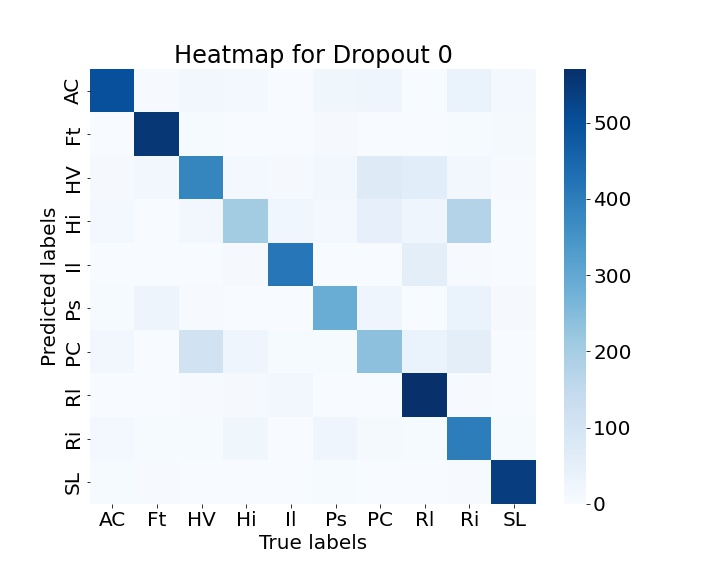



## Conclusions
To summarise, the CNN based model was successfully implemented for the EuroSAT dataset and the max accuracy of 71% was achieved over the test set even with 10 epochs. This was observed for the dropout value of 0. The corresponding training accuracy of the model was 86%. This suggests the model is overfitting to the training dataset. This can be rectified by choosing a dropout value between 0 to 0.5 and other regularisation techniques. Further, the class accuracies of Highway and PermanentCrop classes are very low and thereofre requires special attention.

### Recommendations
Ways to improve the accuracy further:
* Increasing the number of epochs.
* Applying image artificial augmentation to make the model better.
* The River and Highway classes most commonly mispredicted as the other. Taking more images for these two classes and augmenting them in particular can improve the overall accuracy.
* Improving the neural network by adding more layers.
* Trying out other gradient methods like Adamax is plausible but increasing epochs can result in more significant effect.

### References
1. Reproducibility documents. https://pytorch.org/docs/stable/notes/randomness.html
2. Normalising the images and fitting between 0 to 1 to improve accuracy. https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/
3. Logging to console and file simultaneously. https://pythonhowtoprogram.com/logging-in-python-3-how-to-output-logs-to-file-and-console/